In [ ]:
# !conda install -y gdown

/bin/bash: conda: command not found


In [1]:
# gdown command is used to download google drive file using its id
!gdown "1wW-PTHoyVam7YtbDTy-pDGa5ghrajLnr"

Downloading...
From: https://drive.google.com/uc?id=1wW-PTHoyVam7YtbDTy-pDGa5ghrajLnr
To: /content/states_dataset_2.1.zip
100% 1.38G/1.38G [00:09<00:00, 141MB/s]


In [2]:
%%capture --no-display
# unzip command is used to unzipping file 
!unzip states_dataset_2.1.zip

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.callbacks import EarlyStopping , ModelCheckpoint , LearningRateScheduler, ReduceLROnPlateau
import gc

In [2]:
# display list of file in the current directory
os.listdir()

['.config',
 'ground_truth.json',
 '__pycache__',
 'valid',
 'test',
 'test.zip',
 '.ipynb_checkpoints',
 'w_model.h5',
 'states_dataset_2.1.zip',
 'predictions.json',
 'my_best_model.hdf5',
 'utily.py',
 '__MACOSX',
 'app.py',
 'train',
 'sample_data']

In [3]:
# # reading image using its path 
# img = cv2.imread('train/mixed/0002.jpg')
# # cv2 reading image in Blue Green Red to be able to display it we will convert it to Red Green Blue
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# # print the shape of image matrix
# print(img.shape)
# # display image using matplotlib
# plt.imshow(img)

In [4]:
train_path = "train"
test_path = "valid"
# gets the files in train directory which also datalabels , exclude hidden files which start by .
labels = [f for f in os.listdir(train_path) if not f.startswith('.')]
labels

['jullienne',
 'whole',
 'diced',
 'floured',
 'grated',
 'peeled',
 'sliced',
 'mixed',
 'other',
 'juiced',
 'creamy_paste']

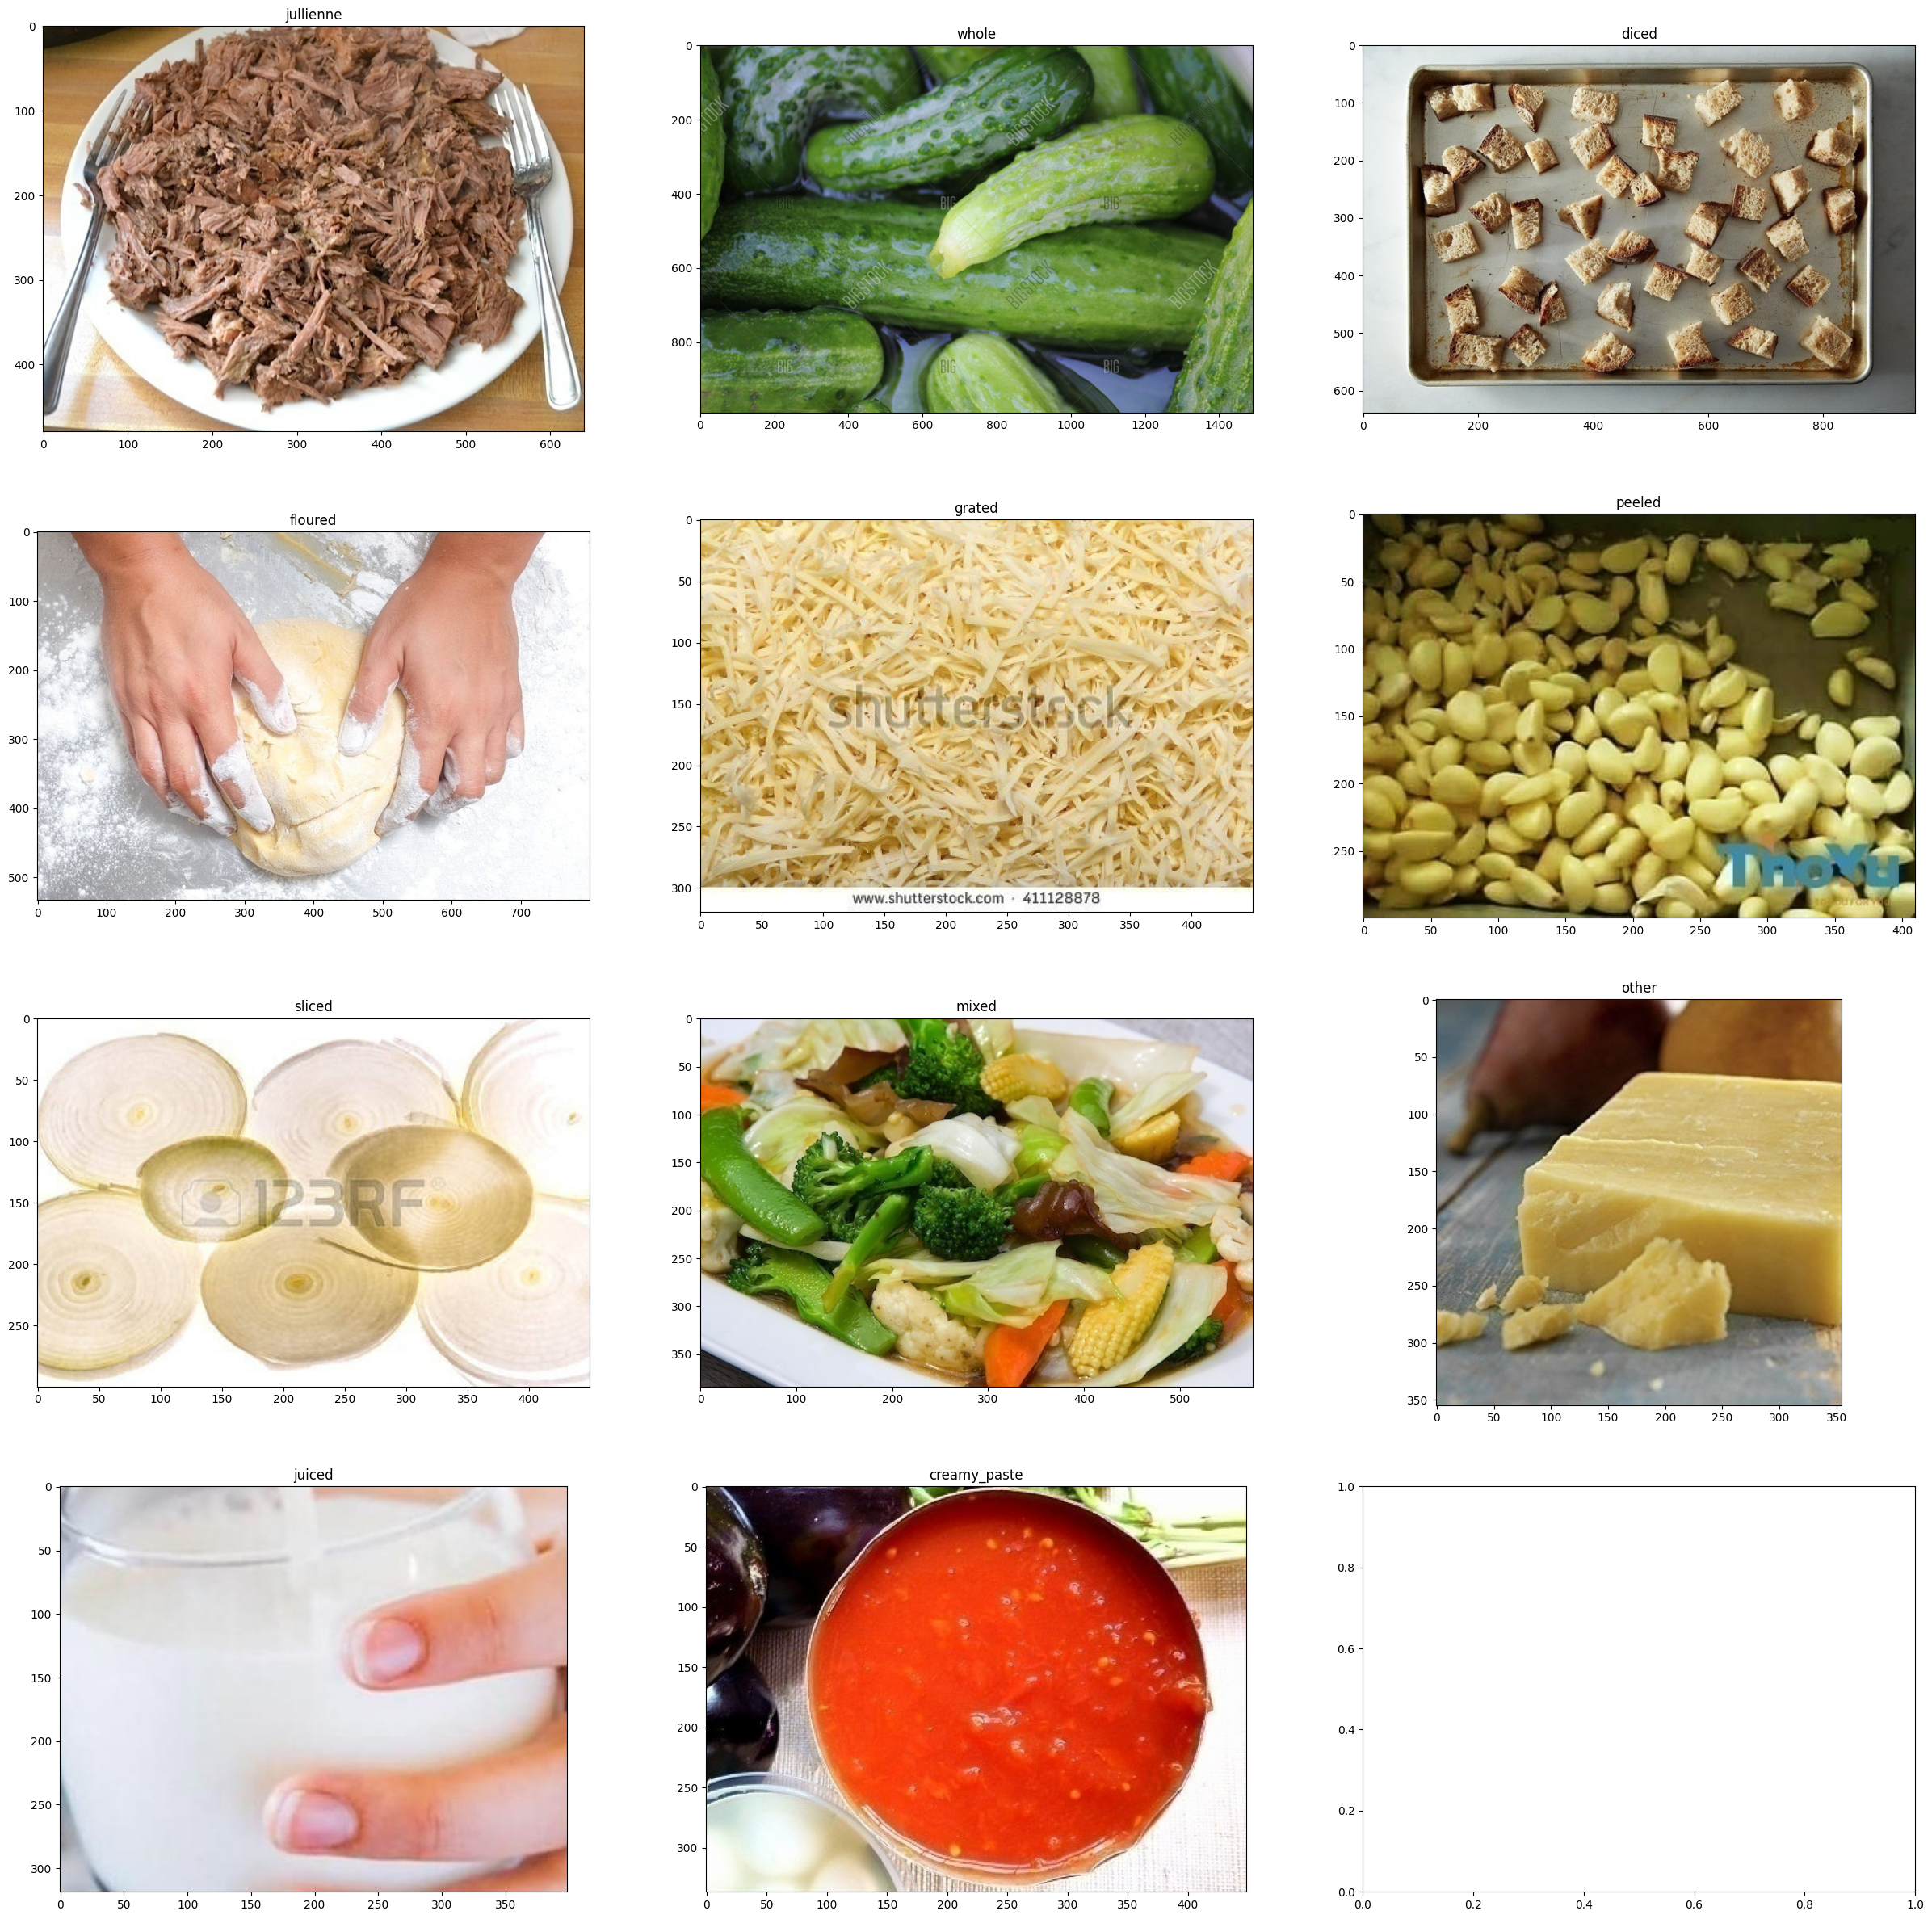

In [5]:
# delare figure and ax with 4 rows and 3 clomns with 30*30 size
fig, ax = plt.subplots(4,3,figsize=(30,30))
for i in range(12):
  try:
  # join label with traning path to get image file path
    inner_images = os.path.join(train_path,labels[i])
  except:
    break
  # gets the first image of the file to display it 
  img = os.listdir(inner_images)[0]
  # get the path of the first image
  full_path = os.path.join(inner_images,img)
  # declare the postion of the image 
  plt.subplot(4,3,i+1)
  # read image using its path
  img = cv2.imread(full_path)
  # cv2 reading image in Blue Green Red to be able to display it we will convert it to Red Green Blue
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title(labels[i])

In [6]:
# label_map is used to convert label from string into number
label_map = {'jullienne': 0,'whole': 1,'diced': 2,'floured': 3,'grated': 4,
             'peeled': 5,'sliced': 6,'mixed': 7,'other': 8,
             'juiced': 9,'creamy_paste': 10}
label_map

{'jullienne': 0,
 'whole': 1,
 'diced': 2,
 'floured': 3,
 'grated': 4,
 'peeled': 5,
 'sliced': 6,
 'mixed': 7,
 'other': 8,
 'juiced': 9,
 'creamy_paste': 10}

In [7]:
def get_data(path,labels):
  # data_dcit is a dictionary consists of two lists one for saving images and another for 
  # save the label of the image 
  data_dict = {"images":[], "labels":[]}
  # loop over the file in training and testing directory
  for label in labels:
    # gets the full path of each file in training and testing files
    inner_path = os.path.join(path,label)
    # loop over the images in label file 
    for item in os.listdir(inner_path):
      # append image path to image list in  data_dict dictionary
      data_dict['images'].append(os.path.join(inner_path,item))
      # append label of image to labels list in data_dict
      data_dict['labels'].append(label_map[label])
  # convert data_dict and convert it to dictionary 
  return pd.DataFrame(data_dict).sample(frac=1)

In [8]:
# pass file and label to the function 
train_data = get_data(train_path,labels)
test_data = get_data(test_path,labels)
# display first 5 rows
train_data.head()

images  labels
8040  train/creamy_paste/0354.jpg      10
3466   train/grated/24.grated.jpg       4
3785        train/peeled/0430.jpg       5
2746       train/floured/0211.jpg       3
5497         train/mixed/0050.jpg       7

In [9]:
# how many images in each label in our trainin data
train_data['labels'].value_counts()

6     1122
1      932
2      898
9      881
8      873
10     757
4      696
7      677
0      607
3      582
5      558
Name: labels, dtype: int64

In [10]:
# declare the size of the image
IMG_SIZE = 128
# declare a list to save preprocessed images in it
train_images = []
# loop over the images in training data 
# tqdm is used to show progress of our function
for path in tqdm(train_data['images']):
  # read image using its path
  img = cv2.imread(path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  train_images.append(img)

100%|██████████| 8583/8583 [01:03<00:00, 135.10it/s]


In [11]:
test_images = []
for path in tqdm(test_data['images']):
  img = cv2.imread(path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  test_images.append(img)

100%|██████████| 1912/1912 [00:13<00:00, 137.29it/s]


In [12]:
# convert images list to numpy array
x_train=np.asarray(train_images) / 255.0
# convert labels to numpy array
y_train = np.asarray(train_data['labels'])

In [13]:
gc.collect()
del train_data

In [14]:
x_test=np.asarray(test_images) / 255.0
y_test = np.asarray(test_data['labels'])

In [15]:
del test_data
gc.collect()

0

In [16]:
# # convert label into one hot encoder representation 
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [17]:
#display the shape of training and testing data
print(f"X train Shape is {x_train.shape}")
print(f"Y train Shape is {y_train.shape}")
print(f"X Test Shape is {x_test.shape}")
print(f"Y test Shape is {y_test.shape}")

X train Shape is (8583, 128, 128, 3)
Y train Shape is (8583,)
X Test Shape is (1912, 128, 128, 3)
Y test Shape is (1912,)


In [18]:
del train_images,test_images
gc.collect()

0

In [19]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(shape=input_shape)

# Convolutional layers with Inception module and residual connections
# Block 1
conv1 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(bn1)

# conv2_1 = Conv2D(filters=32, kernel_size=(1,1), padding='same', activation='relu')(pool1)
# conv2_2 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(conv2_1)
# bn2 = BatchNormalization()(conv2_2)

# print(bn2.shape)
# conv3_1 = Conv2D(filters=32, kernel_size=(1,1), padding='same', activation='relu')(pool1)
# conv3_2 = Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu')(conv3_1)
# bn3 = BatchNormalization()(conv3_2)

# print(bn3.shape)
# conv4_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(pool1)
# conv4_2 = Conv2D(filters=32, kernel_size=(1,1), padding='same', activation='relu')(conv4_1)
# bn4 = BatchNormalization()(conv4_2)
# print(bn4.shape)

# inception1 = Concatenate()([bn2, bn3 , bn4])
# projection = Conv2D(96, kernel_size=(1,1), padding='same')(pool1)

# res1 = Add()([projection, inception1])
# res1 = MaxPooling2D((2, 2), padding='same', strides=(2, 2))(res1)


# Block 2
conv5_1 = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(pool1)
bn5_1 = BatchNormalization()(conv5_1)
conv5_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
bn5_2 = BatchNormalization()(conv5_2)

conv6_1 = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(pool1)
bn6_1 = BatchNormalization()(conv6_1)
conv6_2 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')(bn6_1)
bn6_2 = BatchNormalization()(conv6_2)
conv6_2 = Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu')(bn6_1)
bn6_2 = BatchNormalization()(conv6_2)

conv7_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(pool1)
conv7_2 = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(conv7_1)
bn7_2 = BatchNormalization()(conv7_2)

inception2 = Concatenate()([bn5_2, bn6_2, bn7_2])
projection = Conv2D(192, kernel_size=(1,1), padding='same')(pool1)
res2 = Add()([projection, inception2])
res2 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res2)

print("s",res2.shape)

# Block 3
conv8_1 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(res2)
bn8_1 = BatchNormalization()(conv8_1)
conv8_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn8_1)
bn8_2 = BatchNormalization()(conv8_2)

conv9_1 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(res2)
bn9_1 = BatchNormalization()(conv9_1)
conv9_2 = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')(bn9_1)
bn9_2 = BatchNormalization()(conv9_2)
conv9_2 = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')(bn9_1)
bn9_2 = BatchNormalization()(conv9_2)

conv10_1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(res2)
conv10_2 = Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(conv10_1)
bn10_2 = BatchNormalization()(conv10_2)

inception3 = Concatenate()([bn8_2, bn9_2, bn10_2])
projection = Conv2D(384, kernel_size=(1,1), padding='same')(res2)
res3 = Add()([projection, inception3])
res3 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res3)
print("s3",res3.shape)

# Block 4
conv11_1 = Conv2D(filters=256, kernel_size=(1,1),padding='same',activation='relu')(res3)
conv11_1 = Dropout(.2)(conv11_1)
bn11_1 = BatchNormalization()(conv11_1)
conv11_2 = Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu')(bn11_1)
bn11_2 = BatchNormalization()(conv11_2)

conv12_1 = Conv2D(filters=256,kernel_size=(1,1),padding='same',activation='relu')(res3)
bn12_1 = BatchNormalization()(conv12_1)
conv12_2 = Conv2D(filters=256,kernel_size=(5,5),padding='same',activation='relu')(bn12_1)
bn12_2 = BatchNormalization()(conv12_2)
conv12_2 = Conv2D(filters=256,kernel_size=(5,5),padding='same',activation='relu')(bn12_1)
bn12_2 = BatchNormalization()(conv12_2)

conv13_1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(res3)
conv13_2 = Conv2D(filters=256,kernel_size=(1,1), padding='same', activation='relu')(conv13_1)
bn13_1 = BatchNormalization()(conv13_2)

inception4 = Concatenate()([bn11_2,bn12_2,bn13_1])
projection = Conv2D(768, kernel_size=(1,1), padding='same')(res3)
res4 = Add()([projection, inception4])
res4 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res4)
print("s4",res4.shape)

# Block 4
conv14_1 = Conv2D(filters=512, kernel_size=(1,1),padding='same',activation='relu')(res4)
conv14_1 = Dropout(.2)(conv14_1)
bn14_1 = BatchNormalization()(conv14_1)
conv14_2 = Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu')(bn14_1)
bn14_2 = BatchNormalization()(conv14_2)

conv15_1 = Conv2D(filters=512,kernel_size=(1,1),padding='same',activation='relu')(res4)
bn15_1 = BatchNormalization()(conv15_1)
conv15_2 = Conv2D(filters=512,kernel_size=(5,5),padding='same',activation='relu')(bn15_1)
bn15_2 = BatchNormalization()(conv15_2)

conv16_1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(res4)
conv16_2 = Conv2D(filters=512,kernel_size=(1,1), padding='same', activation='relu')(conv16_1)
bn16_1 = BatchNormalization()(conv16_2)

inception4 = Concatenate()([bn14_2,bn15_2,bn16_1])
projection = Conv2D(1536, kernel_size=(1,1), padding='same')(res4)
res5 = Add()([projection, inception4])
res5 = MaxPooling2D(pool_size=(2,2),padding='same', strides=(2, 2))(res5)

print("s5",res5.shape)


flat_1 = GlobalAveragePooling2D()(res5)
print("s",flat_1.shape)
net = Dense(1024, activation='relu')(flat_1)
net = Dropout(.3)(net)
net = Dense(1024, activation='relu')(net)
net = Dropout(.2)(net)
net = Dense(512, activation='relu')(net)
output = Dense(len(label_map), activation='softmax')(net)

s (None, 32, 32, 192)
s3 (None, 16, 16, 384)
s4 (None, 8, 8, 768)
s5 (None, 4, 4, 1536)
s (None, 1536)


In [20]:
model = Model([inputs], output)

In [21]:
# plot_model(model)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [23]:
# ### Optimizer
#Optimizers are algorithms or methods used to change the attributes of your neural network
# such as weights and learning rate in order to reduce the losses.
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# defines the loss function, the optimizer, and the metrics. 

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['sparse_categorical_accuracy'])

In [24]:
gc.collect()

724

In [25]:
# This line initializes an instance of the ImageDataGenerator class for data augmentation on the training set.
# It applies several transformations to the images such as rotating, shifting, shearing, zooming, and flipping. 
# These augmentations are applied randomly to each image during training to increase the variety of training data. 
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

# This line applies the data augmentation defined by train_datagen to the training set (x_train).
train_datagen.fit(x_train)

# This line initializes an instance of the ImageDataGenerator class for the test set. 
# It is not necessary to apply data augmentation to the test set, so this instance is empty.
test_datagen = ImageDataGenerator()
test_datagen.fit(x_test)

In [26]:
# Initializing EarlyStopping callback object with the following parameters:
# - monitor: The metric being monitored for early stopping. In this case, it's the validation loss.
# - patience: The number of epochs to wait before stopping training if there's no improvement in the monitored metric.
# - restore_best_weights: Whether to restore the weights of the model to the best observed epoch or not.

# es = EarlyStopping(
#                     monitor='validation_loss',
#                     patience=3,
#                     restore_best_weights=True)

# Defining a filepath where the best model will be saved using ModelCheckpoint callback.
# The filepath contains placeholders that will be replaced by the actual values of epoch number and validation loss.
filepath = 'my_best_model.hdf5'

# Initializing ModelCheckpoint callback object with the following parameters:
# - filepath: The path where the best model will be saved.
# - monitor: The metric being monitored for saving the best model. In this case, it's the validation accuracy.
# - verbose: Whether to display information while saving the model or not.
# - save_best_only: Whether to save only the best model or all models during training.
# - mode: Whether to save the model with the maximum or minimum value of the monitored metric.
cp = ModelCheckpoint(filepath=filepath, 
                             monitor='val_sparse_categorical_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

# def schedule(epoch):
#     if epoch < 20 :
#         return .0001
#     else:
#         return .00001

reduce_lr = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=.1, patience=4, min_lr=1e-6)

In [27]:
# train model in training data and use testing for validation 
batch_size = 128
epochs = 50
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = test_datagen.flow(x_test, y_test),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_test.shape[0] // batch_size),
                    callbacks=[cp,reduce_lr])


Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 2.4131 - sparse_categorical_accuracy: 0.2364
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.09152, saving model to my_best_model.hdf5
67/67 [==============================] - 88s 741ms/step - loss: 2.4131 - sparse_categorical_accuracy: 0.2364 - val_loss: 2.5732 - val_sparse_categorical_accuracy: 0.0915 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.9615 - sparse_categorical_accuracy: 0.3143
Epoch 2: val_sparse_categorical_accuracy improved from 0.09152 to 0.09821, saving model to my_best_model.hdf5
67/67 [==============================] - 48s 704ms/step - loss: 1.9615 - sparse_categorical_accuracy: 0.3143 - val_loss: 2.7108 - val_sparse_categorical_accuracy: 0.0982 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.8891 - sparse_categorical_accuracy: 0.3424
Epoch 3: val_sparse_categorical_accuracy improved from 0.09821 to 0.10714, sav

In [28]:
print("Model Performance on test set")
result = model.evaluate(x_test,y_test)
print(dict(zip(model.metrics_names, result)))

Model Performance on test set
60/60 [==============================] - 4s 71ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.6491
{'loss': 1.1364670991897583, 'sparse_categorical_accuracy': 0.6490585803985596}


In [29]:
model.save('model.h5')

In [30]:
def plot_graph(history,string):
    # gets the data stored inside history by a key and plot it
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    # # A legend is an area describing the elements of the graph , in the top right of the graph
    plt.legend()
    # x axis label
    plt.xlabel('epochs')
    # y axis label
    plt.ylabel(string)
    # title
    plt.title(string+' vs epochs')
    plt.show

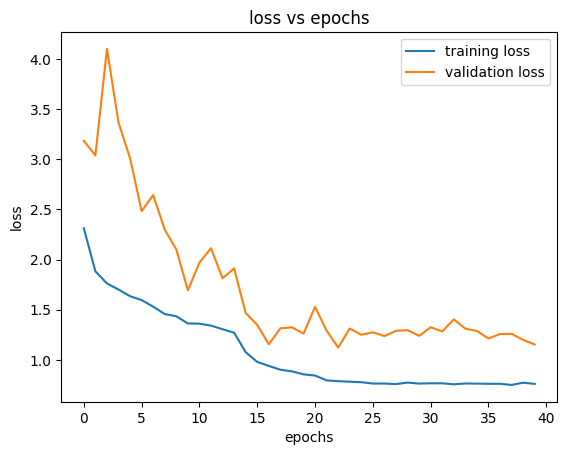

In [32]:
plot_graph(history,'loss')

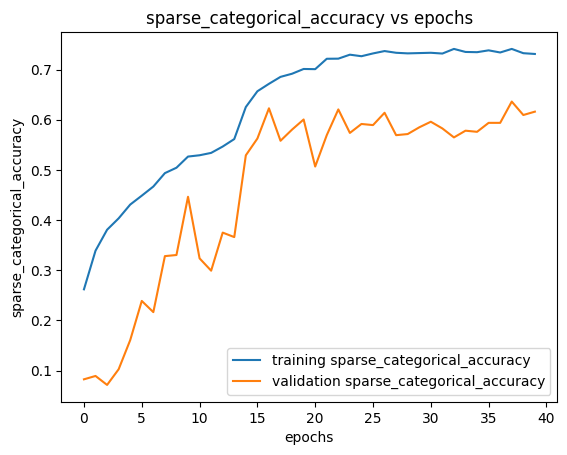

In [33]:
plot_graph(history,'sparse_categorical_accuracy')

In [8]:
from keras.models import load_model

In [9]:
model = load_model('/content/model.h5')

In [24]:
def state_prediction(path,model):
  IMG_SIZE = 128
  # load image using its path
  img = cv2.imread(path)
  # cv2 reading image in Blue Green Red to be able to display it we will convert it to Red Green Blue
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  # changeing the size of image to same size of training images
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE)) 
  # reshape the input data 
  img = np.array(img).reshape(-1,IMG_SIZE,IMG_SIZE,3) 
  img = img / 255.0
  # pass image to get prediction
  prediction = model.predict(img)
  result = np.argmax(prediction)
  print(prediction)
  for k,v in label_map.items():
    if v == result:
      return k
state_prediction('/content/train/juiced/0001.jpg',model)

1/1 [==============================] - 0s 41ms/step
[[1.23826812e-05 8.33486114e-03 2.34559739e-05 1.42254867e-04
  1.75545320e-05 3.49471993e-05 2.18000874e-04 2.59491003e-06
  1.44043015e-02 9.57107425e-01 1.97022371e-02]]


'juiced'

In [38]:
!du -h w_model.h5

198M	w_model.h5


In [1]:
!python app.py

y
2023-04-06 03:32:00.751225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 03:32:02.589140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-06 03:32:06.098213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 03:32:06.412331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA